In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
df = pd.read_excel("p34.xlsx")

In [3]:
# Exibir as primeiras linhas do dataframe
df.head()

,cliente,ECIV,ESCOLARIDADE,IDADE,NATUREZA,PROFISSAO,SEXO,RENDA,UF,STATUS
0,C_12664,casado,secundario,18,1,9,F,14.69,SP,bom
1,C_9694,casado,secundario,18,5,9,M,40.35,SP,bom
2,C_10624,casado,superior,18,1,8,F,24.16,SP,bom
3,C_12230,casado,pos_grad,18,1,8,M,20.74,SP,bom
4,C_21910,casado,secundario,18,1,3,F,50.19,SP,bom


In [4]:
# Verificar valores nulos
print("Valores nulos por coluna:\n", df.isnull().sum())

Valores nulos por coluna:
 cliente         0
ECIV            0
ESCOLARIDADE    0
IDADE           0
NATUREZA        0
PROFISSAO       0
SEXO            0
RENDA           0
UF              0
STATUS          0
dtype: int64


In [5]:
# Unindo estados com menos de 20 registros na categoria "Outros"
counts = df["UF"].value_counts()

small = counts[counts < 20].index

df["UF"] = df["UF"].where(~df["UF"].isin(small), "Outros")
df["UF"].value_counts()

UF
SP        33451
MG         1841
Outros       39
Name: count, dtype: int64

In [6]:
# Garantir que colunas categóricas sejam strings
for col in ["NATUREZA", "PROFISSAO"]:
    df[col] = df[col].astype(str)

In [7]:
# Remover outliers
num_cols = df.select_dtypes(include=[np.number]).columns
z_scores = np.abs(stats.zscore(df[num_cols], nan_policy="omit"))
df_clean = df[(z_scores < 3).all(axis=1)]

In [8]:
# Codificação das variáveis categóricas
label_encoders = {}
for col in ["ECIV", "ESCOLARIDADE", "NATUREZA", "PROFISSAO", "SEXO", "UF", "STATUS"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
print(label_encoders)

{'ECIV': LabelEncoder(), 'ESCOLARIDADE': LabelEncoder(), 'NATUREZA': LabelEncoder(), 'PROFISSAO': LabelEncoder(), 'SEXO': LabelEncoder(), 'UF': LabelEncoder(), 'STATUS': LabelEncoder()}


In [9]:
# Separar variáveis independentes e dependentes
X = df.drop(["cliente ", "STATUS"], axis=1)
y = df["STATUS"]

# Escalonar as features (essencial para SVM)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [10]:
# =============================================
# Criação e treino da rede neural
# =============================================
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation="relu",
    solver="adam",
    max_iter=300,
    random_state=42,
)

mlp.fit(X_train, y_train)

,hidden_layer_sizes,"(100,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


In [11]:
# =============================================
# Avaliação do modelo
# =============================================
y_pred = mlp.predict(X_test)

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nAcurácia:", accuracy_score(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Matriz de Confusão:
[[6243  610]
 [ 716 3031]]

Acurácia: 0.8749056603773585

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      6853
           1       0.83      0.81      0.82      3747

    accuracy                           0.87     10600
   macro avg       0.86      0.86      0.86     10600
weighted avg       0.87      0.87      0.87     10600



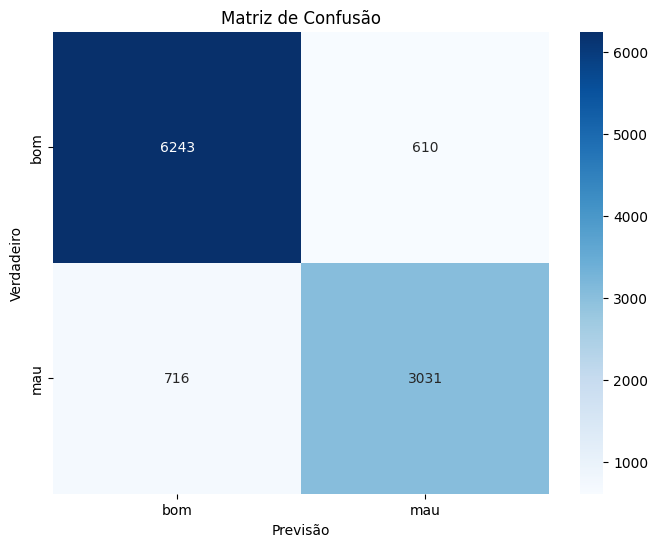

In [12]:
# 1. Heatmap da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoders["STATUS"].classes_,
    yticklabels=label_encoders["STATUS"].classes_,
)
plt.title("Matriz de Confusão")
plt.xlabel("Previsão")
plt.ylabel("Verdadeiro")
plt.show()

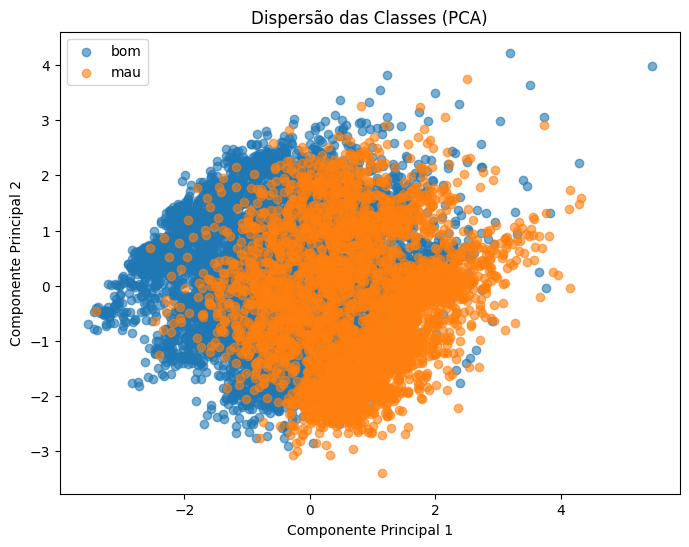

In [13]:
# 2. Gráfico de Dispersão com PCA
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
plt.figure(figsize=(8, 6))
for status in np.unique(y_test):
    idx = y_test == status
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        label=label_encoders["STATUS"].classes_[status],
        alpha=0.6,
    )
plt.title("Dispersão das Classes (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()